In [14]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import math
import os

from parser.parse_csv import get_dt

In [15]:
figures_dir = "figures"
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)

In [16]:
# def latexify(fig_width=None, fig_height=None, columns=1):
#     """Set up matplotlib's RC params for LaTeX plotting.
#     Call this before plotting a figure.

#     Parameters
#     ----------
#     fig_width : float, optional, inches
#     fig_height : float,  optional, inches
#     columns : {1, 2}
#     """

#     # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

#     # Width and max height in inches for IEEE journals taken from
#     # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

#     assert(columns in [1,2])

#     if fig_width is None:
#         fig_width = 3.39 if columns==1 else 6.9 # width in inches

#     if fig_height is None:
#         golden_mean = (math.sqrt(5)-1.0)/2.0    # Aesthetic ratio
#         fig_height = fig_width*golden_mean # height in inches
    
#     MAX_HEIGHT_INCHES = 8.0
#     if fig_height > MAX_HEIGHT_INCHES:
#         print("WARNING: fig_height too large:" + fig_height + 
#               "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
#         fig_height = MAX_HEIGHT_INCHES

#     params = {'backend': 'ps',
#               'text.latex.preamble': ["\\usepackage{libertine}"],
#               'axes.labelsize': 8, # fontsize for x and y labels (was 10)
#               'axes.titlesize': 8,
# #               'text.fontsize': 8, # was 10
#               'legend.fontsize': 8, # was 10
#               'xtick.labelsize': 8,
#               'ytick.labelsize': 8,
#               'text.usetex': True,
#               'figure.figsize': [fig_width, fig_height],
#               'font.family': 'serif',
#               'mathtext.default': 'regular'
#     }

#     matplotlib.rcParams.update(params)

# %matplotlib inline

# latexify()

In [17]:
mnist_valid_labels = pd.read_csv("parser/mnist_valid_labels.csv").set_index("SampleNumber")
mnist_test_labels = pd.read_csv("parser/mnist_test_labels.csv").set_index("SampleNumber")

In [37]:
def get_accuracies_valid(filename):
    dt = get_dt(filename, mnist_valid_labels)

    adv_results = dt.groupby("ProcessedSolveStatus")["SolveStatus"].count().to_dict()
    print(adv_results)
    cumulative_adv_results = []
    accumulator = adv_results["ProvablyRobustByClass"]
    del adv_results["ProvablyRobustByClass"]
    adv_results_numbers = {}
    for k, v in adv_results.items():
        if k.startswith("InfeasibleDistance"):
            dist = float(k[18:])
        elif k.startswith("InfeasibleUndecidedDistance"):
            dist = float(k[27:])
        else:
            continue
        adv_results_numbers[dist] = adv_results_numbers.get(dist, 0) + v
    for i in range(-24, 41):
        if i / 10 in adv_results_numbers:
            accumulator += adv_results_numbers[i / 10]
        cumulative_adv_results.append(accumulator)
    # Exclude 4.0 distance
    cumulative_adv_results = cumulative_adv_results[:-1]

    if "StatusUnknown" in adv_results:
        accumulator += adv_results["StatusUnknown"]
    
    if accumulator != 5000:
        print("Only", accumulator, "samples verified so far")

    nat_results = [
        np.logical_and(
            dt["NaturalInputMinDistance"].values >= x / 10,
            (dt.PredictedIndex == dt.TrueIndex).values
        ).sum()
        for x in range(-24, 40) # Exclude 4.0 distance
    ]

    return (np.asarray(nat_results) / accumulator,
        np.asarray(cumulative_adv_results) / accumulator)

def get_accuracies_test(filename, threshold=None):
    dt = get_dt(filename, mnist_test_labels)

    if threshold is not None:
        nat_results = np.logical_and(dt["NaturalInputMinDistance"].values >= threshold,
                                     (dt.PredictedIndex == dt.TrueIndex).values).sum()
    else:
        nat_results = (dt.PredictedIndex == dt.TrueIndex).values.sum()

    adv_results = dt.groupby("ProcessedSolveStatus")["PredictedIndex"].count().to_dict()
    
    print(adv_results)
    
    if "InfeasibleDistance" in adv_results:
        adv_results["ProvablyRobustByClass"] += adv_results["InfeasibleDistance"]

    return (nat_results / dt["PredictedIndex"].count(),
            adv_results["ProvablyRobustByClass"] / dt["PredictedIndex"].count())

## Test results

In [19]:
for dataset, eps in zip(["IBP_MNIST_SmallCNN_train_0.200_eval_0.100_elide/Apr29_22-00-04/weights_100_0.971__linf-norm-bounded-0.1__Inf__0.0",
                         "IBP_MNIST_MediumCNN_train_0.200_eval_0.100_elide/Apr29_21-58-36/weights_100_0.973__linf-norm-bounded-0.1__Inf__0.0",
                         "IBP_MNIST_SmallCNN_train_0.300_eval_0.200_elide/May01_09-41-57/weights_100_0.946__linf-norm-bounded-0.2__Inf__0.0",
                         "IBP_MNIST_MediumCNN_train_0.300_eval_0.200_elide/May01_10-45-41/weights_100_0.953__linf-norm-bounded-0.2__Inf__0.0",
                         "IBP_MNIST_SmallCNN_train_0.400_eval_0.300_elide/Apr29_22-01-57/weights_100_0.906__linf-norm-bounded-0.3__Inf__0.0",
                         "IBP_MNIST_MediumCNN_train_0.400_eval_0.300_elide/Apr29_21-55-33/weights_100_0.915__linf-norm-bounded-0.3__Inf__0.0"],
                         [0.1, 0.1, 0.2, 0.2, 0.3, 0.3]):
    filename = "verification_results/test/" + dataset + "/summary.csv"
    print(dataset)
    print(get_accuracies_test(filename))
    print()

IBP_MNIST_SmallCNN_train_0.200_eval_0.100_elide/Apr29_22-00-04/weights_100_0.971__linf-norm-bounded-0.1__Inf__0.0
{'ProvablyRobustByClass': 9688, 'Vulnerable': 312}
(0.9843, 0.9688)

IBP_MNIST_MediumCNN_train_0.200_eval_0.100_elide/Apr29_21-58-36/weights_100_0.973__linf-norm-bounded-0.1__Inf__0.0
{'StatusUnknown': 1, 'ProvablyRobustByClass': 9732, 'Vulnerable': 267}
(0.9868, 0.9732)

IBP_MNIST_SmallCNN_train_0.300_eval_0.200_elide/May01_09-41-57/weights_100_0.946__linf-norm-bounded-0.2__Inf__0.0
{'ProvablyRobustByClass': 9389, 'Vulnerable': 611}
(0.9762, 0.9389)

IBP_MNIST_MediumCNN_train_0.300_eval_0.200_elide/May01_10-45-41/weights_100_0.953__linf-norm-bounded-0.2__Inf__0.0
{'StatusUnknown': 5, 'ProvablyRobustByClass': 9524, 'Vulnerable': 471}
(0.9814, 0.9524)

IBP_MNIST_SmallCNN_train_0.400_eval_0.300_elide/Apr29_22-01-57/weights_100_0.906__linf-norm-bounded-0.3__Inf__0.0
{'ProvablyRobustByClass': 8941, 'Vulnerable': 1059}
(0.9652, 0.8941)

IBP_MNIST_MediumCNN_train_0.400_eval_0.300

## MNIST 0.1

Maximise nat and adv accuracy at epsilon =  0.4
Nat accuracy 0.9798
Adv accuracy 0.98 

Maximise nat and adv accuracy at epsilon =  0.6
Nat accuracy 0.9836
Adv accuracy 0.9832 

Maximise nat and adv accuracy at epsilon =  0.1
Nat accuracy 0.9874
Adv accuracy 0.9874 



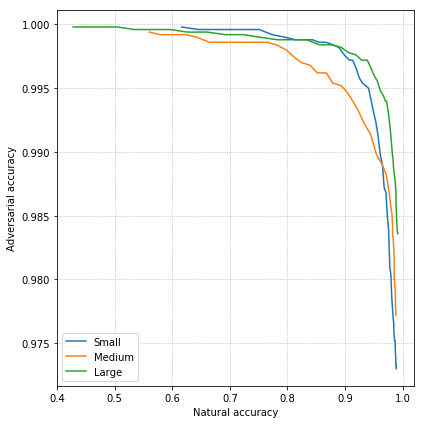

In [20]:
plt.figure()

# Set height = width
fig = plt.gcf()
width, height = fig.get_size_inches()
fig.set_size_inches(width, width)

for dataset, label in zip(["IBP_MNIST_SmallCNN_train_0.200_eval_0.100_elide/Apr29_22-00-04/weights_100_0.971__linf-norm-bounded-0.1__Inf__0.0",
                           "IBP_MNIST_MediumCNN_train_0.200_eval_0.100_elide/Apr29_21-58-36/weights_100_0.973__linf-norm-bounded-0.1__Inf__0.0",
                           "IBP_MNIST_LargeCNN_train_0.200_eval_0.100_elide/Apr29_21-41-43/weights_100_0.980__linf-norm-bounded-0.1__Inf__0.0"],
                          ["Small", "Medium", "Large"]):

    filename = "verification_results/validation/" + dataset + "/summary.csv"
    nat_accuracies, adv_accuracies = get_accuracies_valid(filename)
    plt.plot(nat_accuracies, adv_accuracies, label=label)
    plt.xlabel("Natural accuracy")
    plt.ylabel("Adversarial accuracy")

    plt.grid(True, "both", linestyle="dotted")

    max_min = 0
    nat_acc = -1
    adv_acc = -1
    epsilon = 0
    for (a, b, c) in zip(nat_accuracies, adv_accuracies, range(-24, 41)):
        if min(a, b) > max_min:
            max_min = min(a, b)
            nat_acc = a
            adv_acc = b
            epsilon = c / 10

    print("Maximise nat and adv accuracy at epsilon = ", epsilon)
    print("Nat accuracy", nat_acc)
    print("Adv accuracy", adv_acc, "\n")

# plt.axis([0.5,1,0.97,1])
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, "verif_results_mnist_valid.pdf"), bbox_inches="tight", pad_inches=0)

In [21]:
large_01_test = "verification_results/test_min_dist_0.1/IBP_MNIST_LargeCNN_train_0.200_eval_0.100_elide/Apr29_21-41-43/weights_100_0.980__linf-norm-bounded-0.1__Inf__0.0/summary.csv"
print(get_accuracies_test(large_01_test, 0.1))

{'StatusUnknown': 4, 'InfeasibleDistance': 59, 'ProvablyRobustByClass': 9776, 'Vulnerable': 161}
(0.9834, 0.9835)


## MNIST 0.2

Maximise nat and adv accuracy at epsilon =  0.9
Nat accuracy 0.9672
Adv accuracy 0.968 

Maximise nat and adv accuracy at epsilon =  1.0
Nat accuracy 0.9708
Adv accuracy 0.971 

Maximise nat and adv accuracy at epsilon =  0.7
Nat accuracy 0.9746
Adv accuracy 0.9738 



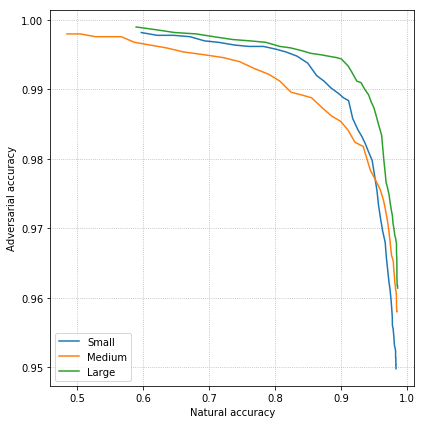

In [24]:
plt.figure()

# Set height = width
fig = plt.gcf()
width, height = fig.get_size_inches()
fig.set_size_inches(width, width)

for dataset, label in zip(["IBP_MNIST_SmallCNN_train_0.300_eval_0.200_elide/May01_09-41-57/weights_100_0.946__linf-norm-bounded-0.2__Inf__0.0",
                           "IBP_MNIST_MediumCNN_train_0.300_eval_0.200_elide/May01_10-45-41/weights_100_0.953__linf-norm-bounded-0.2__Inf__0.0",
                           "IBP_MNIST_LargeCNN_train_0.300_eval_0.200_elide/May01_10-46-22/weights_100_0.956__linf-norm-bounded-0.2__Inf__0.0"],
                          ["Small", "Medium", "Large"]):

    filename = "verification_results/validation/" + dataset + "/summary.csv"
    nat_accuracies, adv_accuracies = get_accuracies_valid(filename)
    plt.plot(nat_accuracies, adv_accuracies, label=label)
    plt.xlabel("Natural accuracy")
    plt.ylabel("Adversarial accuracy")

    plt.grid(True, "both", linestyle="dotted")

    max_min = 0
    nat_acc = -1
    adv_acc = -1
    epsilon = 0
    for (a, b, c) in zip(nat_accuracies, adv_accuracies, range(-24, 41)):
        if min(a, b) > max_min:
            max_min = min(a, b)
            nat_acc = a
            adv_acc = b
            epsilon = c / 10

    print("Maximise nat and adv accuracy at epsilon = ", epsilon)
    print("Nat accuracy", nat_acc)
    print("Adv accuracy", adv_acc, "\n")

# plt.axis([0.5,1,0.95,1])
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, "verif_results_mnist_valid.pdf"), bbox_inches="tight", pad_inches=0)

In [39]:
large_02_test = "verification_results/test_min_dist_0.7/IBP_MNIST_LargeCNN_train_0.300_eval_0.200_elide/May01_10-46-22/weights_100_0.956__linf-norm-bounded-0.2__Inf__0.0/summary.csv"
print(get_accuracies_test(large_02_test, 0.7))

{'StatusUnknown': 12, 'InfeasibleDistance': 19, 'ProvablyRobustByClass': 1068, 'Vulnerable': 37}
(0.9612676056338029, 0.9568661971830986)


## MNIST 0.3

{'InfeasibleDistance-0.6': 3, 'InfeasibleDistance1.6': 12, 'InfeasibleDistance-2.2': 1, 'InfeasibleDistance1.8': 10, 'InfeasibleDistance1.9': 12, 'InfeasibleDistance1.0': 20, 'InfeasibleDistance-0.5': 1, 'InfeasibleDistance2.7': 8, 'InfeasibleDistance2.2': 9, 'InfeasibleDistance4': 19, 'InfeasibleDistance0.9': 19, 'InfeasibleDistance-1.9': 2, 'InfeasibleDistance3.3': 5, 'InfeasibleDistance1.3': 12, 'InfeasibleDistance2.1': 9, 'InfeasibleDistance-0.2': 7, 'InfeasibleDistance-0.3': 5, 'InfeasibleDistance1.2': 23, 'InfeasibleDistance-0.4': 2, 'InfeasibleDistance-0.7': 2, 'InfeasibleDistance-1.4': 1, 'InfeasibleDistance0.5': 10, 'InfeasibleDistance3.0': 5, 'InfeasibleDistance1.1': 12, 'InfeasibleDistance2.5': 10, 'InfeasibleDistance2.8': 7, 'InfeasibleDistance1.5': 22, 'InfeasibleDistance2.9': 3, 'InfeasibleDistance0.2': 9, 'InfeasibleDistance2.4': 6, 'InfeasibleDistance2.3': 11, 'InfeasibleDistance-0.1': 7, 'InfeasibleDistance3.9': 2, 'InfeasibleDistance3.8': 1, 'InfeasibleDistance-0.8': 

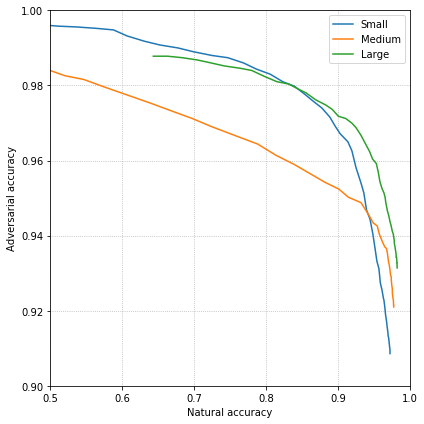

In [41]:
plt.figure()

# Set height = width
fig = plt.gcf()
width, height = fig.get_size_inches()
fig.set_size_inches(width, width)

for dataset, label in zip(["IBP_MNIST_SmallCNN_train_0.400_eval_0.300_elide/Apr29_22-01-57/weights_100_0.906__linf-norm-bounded-0.3__Inf__0.0",
                           "IBP_MNIST_MediumCNN_train_0.400_eval_0.300_elide/Apr29_21-55-33/weights_100_0.915__linf-norm-bounded-0.3__Inf__0.0",
                           "IBP_MNIST_LargeCNN_train_0.400_eval_0.300_elide/Apr29_21-47-39/weights_100_0.926__linf-norm-bounded-0.3__Inf__0.0"],
                          ["Small", "Medium", "Large"]):

    filename = "verification_results/validation/" + dataset + "/summary.csv"
    nat_accuracies, adv_accuracies = get_accuracies_valid(filename)
    
    plt.plot(nat_accuracies, adv_accuracies, label=label)
    plt.xlabel("Natural accuracy")
    plt.ylabel("Adversarial accuracy")

    plt.grid(True, "both", linestyle="dotted")

    max_min = 0
    nat_acc = -1
    adv_acc = -1
    epsilon = 0
    for (a, b, c) in zip(nat_accuracies, adv_accuracies, range(-24, 41)):
        if min(a, b) > max_min:
            max_min = min(a, b)
            nat_acc = a
            adv_acc = b
            epsilon = c / 10

    print("Maximise nat and adv accuracy at epsilon = ", epsilon)
    print("Nat accuracy", nat_acc)
    print("Adv accuracy", adv_acc, "\n")

plt.axis([0.5,1,0.90,1])
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, "verif_results_mnist_valid.pdf"), bbox_inches="tight", pad_inches=0)

In [40]:
large_02_test = "verification_results/test_min_dist_1.3/IBP_MNIST_LargeCNN_train_0.400_eval_0.300_elide/Apr29_21-47-39/weights_100_0.926__linf-norm-bounded-0.3__Inf__0.0/summary.csv"
print(get_accuracies_test(large_02_test, 1.3))

{'StatusUnknown': 4, 'InfeasibleDistance': 8, 'ProvablyRobustByClass': 219, 'Vulnerable': 5}
(0.9576271186440678, 0.961864406779661)
